In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import yfinance as yf # type: ignore

# Load financial data

In [2]:
data = yf.download('AAPL', start='2019-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2019-01-02,37.708595,39.480000,39.712502,38.557499,38.722500,148158800
2019-01-03,33.952541,35.547501,36.430000,35.500000,35.994999,365248800
2019-01-04,35.401955,37.064999,37.137501,35.950001,36.132500,234428400
2019-01-07,35.323166,36.982498,37.207500,36.474998,37.174999,219111200
2019-01-08,35.996525,37.687500,37.955002,37.130001,37.389999,164101200


In [4]:
X = data.to_numpy()
X.shape

(1258, 6)

In [5]:
print(np.round(X[0], 4))

[3.770860e+01 3.948000e+01 3.971250e+01 3.855750e+01 3.872250e+01
 1.481588e+08]


In [6]:
import torch

In [7]:
x = torch.randn(30)
y = torch.randn(30)

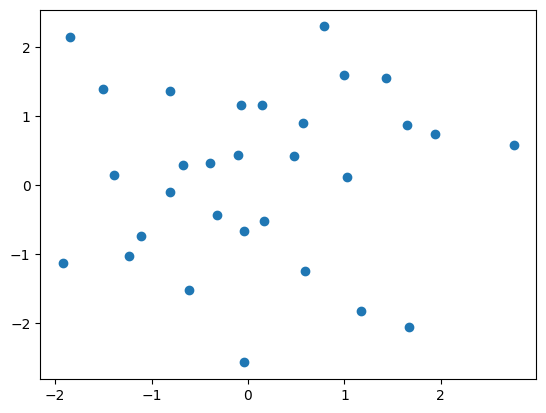

In [8]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.show()

In [9]:
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available, using CPU.")

CUDA is available!


In [11]:
# Create a tensor
tensor = torch.randn(3, 3)

# Print the device of the tensor
print(tensor.device)

# Move tensor to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor = tensor.to(device)

# Print the device after moving tensor
print(tensor.device)


cpu
cuda:0
